In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Function to read in y_true, pscore_true, and tau_true from orig data file
# Used for X-meta training preds, because those are messed up
def get_true_y_p_tau(preds_df, orig_data):
    preds_df['y_true'] = orig_data['Y']
    preds_df['pscore_true'] = orig_data['pscore']
    preds_df['tau_true'] = orig_data['tau']
    
    # also create more manageably named y0/y1 pred columns
    preds_df['y0_preds'] = preds_df['y0_treat_preds']
    preds_df['y1_preds'] = preds_df['y1_control_preds']
    return preds_df


# Function to get potential outcomes (y0 and y1)
# from preds_df y_true and tau_true
def get_true_potential_outcomes(preds_df):
    
    # Initialize y0 and y1
    preds_df['y0_true'] = np.nan
    preds_df['y1_true'] = np.nan
    
    # Get tau for treat and for control
    tau_control = preds_df.loc[preds_df.W==0, 'tau_true']
    tau_treat = preds_df.loc[preds_df.W==1, 'tau_true']
    
    # Get observed outcomes
    preds_df.loc[preds_df.W==0, 'y0_true'] = preds_df.loc[preds_df.W==0, 'y_true']
    preds_df.loc[preds_df.W==1, 'y1_true'] = preds_df.loc[preds_df.W==1, 'y_true']
    
    # Reconstruct unobserved outcomes
    preds_df.loc[preds_df.W==0, 'y1_true'] = preds_df.loc[preds_df.W==0, 'y0_true'] + tau_control
    
    preds_df.loc[preds_df.W==1, 'y0_true'] = preds_df.loc[preds_df.W==1, 'y1_true'] - tau_treat
    
    return preds_df


# Function to calculate prediction errors
# NOTE: Could experiment with plotting absolute value of training errors
def get_pred_error(preds_df):
    
    # get list of all columns we can calculate a prediction error for
    pred_cols = [x.replace('_preds', '') for x in preds_df.columns if 'preds' in x]
    true_cols = [x.replace('_true', '') for x in preds_df.columns if 'true' in x]
    err_cols = set(pred_cols) & set(true_cols)
    
    # calculate and save prediction error for each
    for col in err_cols:
        preds_df[col+'_err'] = preds_df[col+'_preds'] - preds_df[col+'_true']
        
    return preds_df
    

In [3]:
all_configs = ['iw_g_logreg_default', 'iw_g_rfc_default', 'rf_g_logreg_default', 
                     'rf_g_rfc_default', 'rf_g_rfc_authors', 'rf_g_rfc_tuned']


def get_plots(sim, all_configs):
    # Define figures
    fig_y, axs_y = plt.subplots(len(all_configs), 3, sharex=True, sharey=True, figsize=(12,20))
    fig_y.suptitle('sim{}:'.format(sim)+r' $Y_{true}$ vs. $Y_{pred}$', fontsize=16, y=0.92)
    fig_t, axs_t = plt.subplots(len(all_configs), 3, sharex=True, sharey=True, figsize=(12,20))
    fig_t.suptitle('sim{}:'.format(sim)+r' $\tau_{true}$ vs. $\tau_{pred}$', fontsize=16, y=0.92)
    fig_e, axs_e = plt.subplots(len(all_configs), 2, sharex=True, sharey=True, figsize=(10,20))
    fig_e.suptitle('sim{}:'.format(sim)+r' Error in $Y$ vs. error in $\tau$', fontsize=16, y=0.92)
    fig_p, axs_p = plt.subplots(len(all_configs), 2, sharex=True, figsize=(10, 20))
    fig_g, axs_g = plt.subplots(2, sharey=True, figsize=(5,8))
    fig_g.suptitle('sim{}:'.format(sim)+' $\pi$ predictions for importance weights', fontsize=16, y=0.95)
    
    # read in original training set (will be used for X-learner)
    train = pd.read_parquet('../data/sim{}/samp1_train.parquet'.format(sim))
    for m, meta in enumerate(['S', 'T', 'X']):
        for c, config in enumerate(all_configs):
            # read in test set predictions
            test_preds = pd.read_parquet('preds/{}_sim{}_{}_test_preds.parquet'\
                                        .format(meta, sim, config))
            # Add y0_true and y1_true columns
            test_preds = get_true_potential_outcomes(test_preds)
            # Calculate prediction errors
            test_preds = get_pred_error(test_preds)
            
            # plot tau_true vs. tau_preds
            axs_t[c, m].scatter(test_preds[test_preds.W==0]['tau_true'], 
                                test_preds[test_preds.W==0]['tau_preds'], 
                                color='tab:blue', alpha=0.2, label='W=0')
            axs_t[c, m].scatter(test_preds[test_preds.W==1]['tau_true'], 
                                test_preds[test_preds.W==1]['tau_preds'], 
                                color='tab:orange', alpha=0.2, label='W=1')
            axs_t[c, m].set_title('config={}, meta={}'.format(config, meta))
            axs_t[c, m].set_xlabel(r'$\tau_{true}$')
            axs_t[c, m].set_ylabel(r'$\tau_{pred}$')
            axs_t[c, m].legend(loc=1)
            
            if meta=='X':
                # also read in training predictions
                train_preds = pd.read_parquet('preds/{}_sim{}_{}_train_preds.parquet'\
                                              .format(meta, sim, config))
                # fix y_true, pscore_true, and tau_true
                train_preds = get_true_y_p_tau(train_preds, train)
                # Add y0_true and y1_true columns
                train_preds = get_true_potential_outcomes(train_preds)
                # Calculate prediction errors
                train_preds = get_pred_error(train_preds)
                
                # PLOTTING NOTE:
                # All plots should be color-coded by W
                # plot thing1 vs. thing2 means thing1 should be Xaxis & thing2 should be Yaxis
                
                # plot pscore_true vs. pscore_preds
                axs_p[c, 0].scatter(test_preds[test_preds.W==0]['pscore_true'], 
                                    test_preds[test_preds.W==0]['pscore_preds'], 
                                    color='tab:blue', alpha=0.2, label='W=0')
                axs_p[c, 0].scatter(test_preds[test_preds.W==1]['pscore_true'], 
                                    test_preds[test_preds.W==1]['pscore_preds'], 
                                    color='tab:orange', alpha=0.2, label='W=1')
                axs_p[c, 0].set_title('config={}, meta={}'.format(config, meta))
                axs_p[c, 0].set_xlabel(r'$\pi_{true}$')
                axs_p[c, 0].set_ylabel(r'$\pi_{pred}$')
                axs_p[c, 0].legend(loc=1)
               
                # plot pscore_err vs. tau_err
                axs_p[c, 1].scatter(test_preds[test_preds.W==0]['pscore_err'], 
                                    test_preds[test_preds.W==0]['tau_err'], 
                                    color='tab:blue', alpha=0.2, label='W=0')
                axs_p[c, 1].scatter(test_preds[test_preds.W==1]['pscore_err'], 
                                    test_preds[test_preds.W==1]['tau_err'], 
                                    color='tab:orange', alpha=0.2, label='W=1')
                axs_p[c, 1].set_title('config={}, meta={}'.format(config, meta))
                axs_p[c, 1].set_xlabel(r'Error in $\pi$')
                axs_p[c, 1].set_ylabel(r'Error in $\tau$')
                axs_p[c, 1].legend(loc=1)
                
                # plot y0_true vs. y0_preds (for people who have W =1) (on same plot as the 1 below if x-scales alignable)
                # plot y1_true vs. y1_preds (for people who have W =0) (on same plot as the 1 above if x-scales alignable)
                axs_y[c, m].scatter(train_preds['y0_true'], 
                                    train_preds['y0_preds'], 
                                    color='tab:blue', alpha=0.2, label='W=0')
                axs_y[c, m].scatter(train_preds['y1_true'], 
                                    train_preds['y1_preds'], 
                                    color='tab:orange', alpha=0.2, label='W=1')
                axs_y[c, m].set_title('config={}, meta={}'.format(config, meta))
                axs_y[c, m].set_xlabel(r'$Y_{true}$')
                axs_y[c, m].set_ylabel(r'$Y_{pred}$')
                axs_y[c, m].legend(loc=1)
                
                # can't plot y_err vs. tau_err for X because y_err is in train and tau_err is in test
#                 # plot y0_err vs. tau_err (on same plot as the 1 below if x-scales alignable)
#                 # plot y1_err vs. tau_err (on same plot as the 1 above if x-scales alignable)
#                 axs_e[c, m].scatter(train_preds['y0_err'], 
#                                     train_preds['tau_err'], 
#                                     color='tab:blue', alpha=0.1)
#                 axs_e[c, m].scatter(train_preds['y1_err'], 
#                                     train_preds['tau_err'], 
#                                     color='tab:orange', alpha=0.1)
#                 axs_e[c, m].set_title('config={}, meta={}'.format(config, meta))
#                 axs_e[c, m].set_xlabel('y_err')
#                 axs_e[c, m].set_ylabel('tau_err')
                
                if config=='iw_g_logreg_default':
                    # TO DO for train_preds, to the above ADD:
                    # plot pscore_true vs. pscore_preds
                    axs_g[0].scatter(train_preds[train_preds.W==0]['pscore_true'], 
                                        train_preds[train_preds.W==0]['pscore_preds'], 
                                        color='tab:blue', alpha=0.2, label='W=0')
                    axs_g[0].scatter(train_preds[train_preds.W==1]['pscore_true'], 
                                        train_preds[train_preds.W==1]['pscore_preds'], 
                                        color='tab:orange', alpha=0.2, label='W=1')
                    axs_g[0].set_title('config={}, meta={}'.format(config, meta))
                    axs_g[0].set_xlabel(r'$\pi_{true}$')
                    axs_g[0].set_ylabel(r'$\pi_{pred}$')
                    axs_g[0].legend(loc=1)
                if config=='iw_g_rfc_default':
                    axs_g[1].scatter(train_preds[train_preds.W==0]['pscore_true'], 
                                        train_preds[train_preds.W==0]['pscore_preds'], 
                                        color='tab:blue', alpha=0.2, label='W=0')
                    axs_g[1].scatter(train_preds[train_preds.W==1]['pscore_true'], 
                                        train_preds[train_preds.W==1]['pscore_preds'], 
                                        color='tab:orange', alpha=0.2, label='W=1')
                    axs_g[1].set_title('config={}, meta={}'.format(config, meta))
                    axs_g[1].set_xlabel(r'$\pi_{true}$')
                    axs_g[1].set_ylabel(r'$\pi_{pred}$')
                    axs_g[1].legend(loc=1)
                
            if meta=='T' or meta=='S':
                # plot y0_true vs y0_preds
                # plot y1_true vs. y1_preds
                axs_y[c, m].scatter(test_preds['y0_true'],
                                    test_preds['y0_preds'], 
                                    color='tab:blue', alpha=0.2, label='W=0')
                axs_y[c, m].scatter(test_preds['y1_true'],
                                    test_preds['y1_preds'], 
                                    color='tab:orange', alpha=0.2, label='W=1')
                axs_y[c, m].set_title('config={}, meta={}'.format(config, meta))
                axs_y[c, m].set_xlabel(r'$Y_{true}$')
                axs_y[c, m].set_ylabel(r'$Y_{pred}$')
                axs_y[c, m].legend(loc=1)
                
                # plot y0_err vs tau_preds (on same plot as the 1 below if x-scales alignable)
                # plot y1_err vs. tau_preds (on same plot as the 1 above if x-scales alignable)
                axs_e[c, m].scatter(test_preds['y0_err'], 
                                    test_preds['tau_err'], 
                                    color='tab:blue', alpha=0.2, label='W=0')
                axs_e[c, m].scatter(test_preds['y1_err'], 
                                    test_preds['tau_err'], 
                                    color='tab:orange', alpha=0.2, label='W=1')
                axs_e[c, m].set_title('config={}, meta={}'.format(config, meta))
                axs_e[c, m].set_xlabel(r'Error in $Y$')
                axs_e[c, m].set_ylabel(r'Error in $\tau$')
                axs_e[c, m].legend(loc=1)


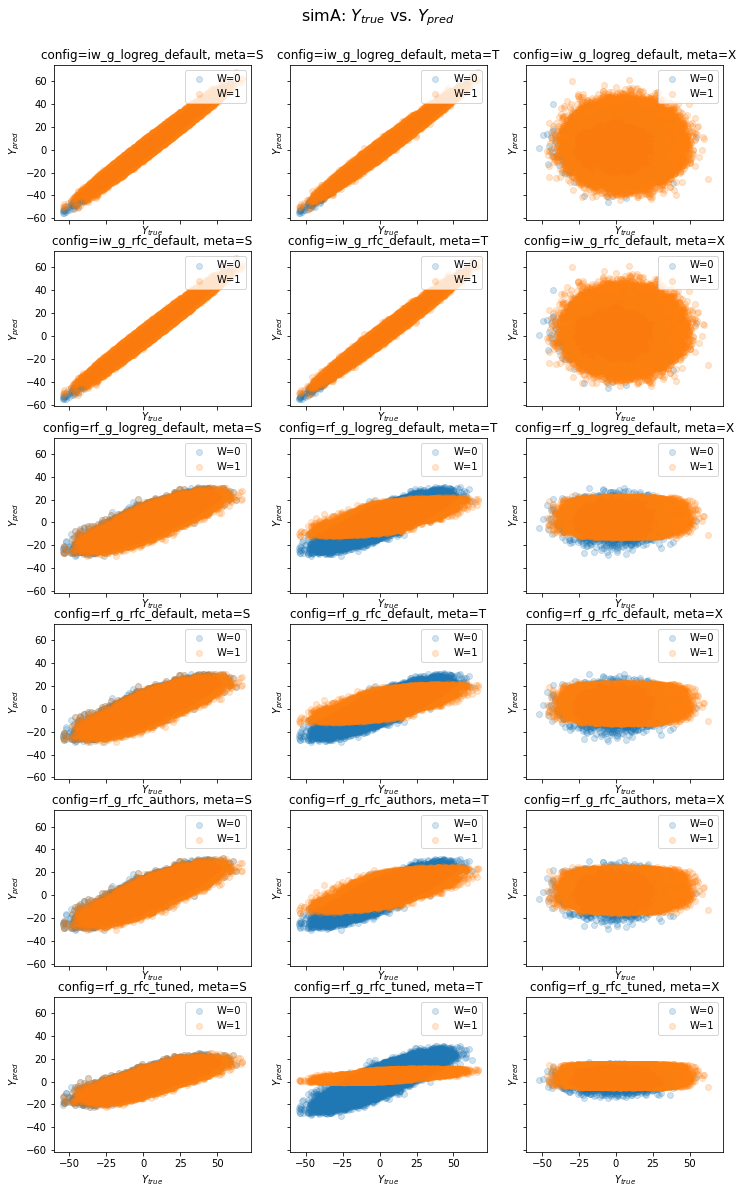

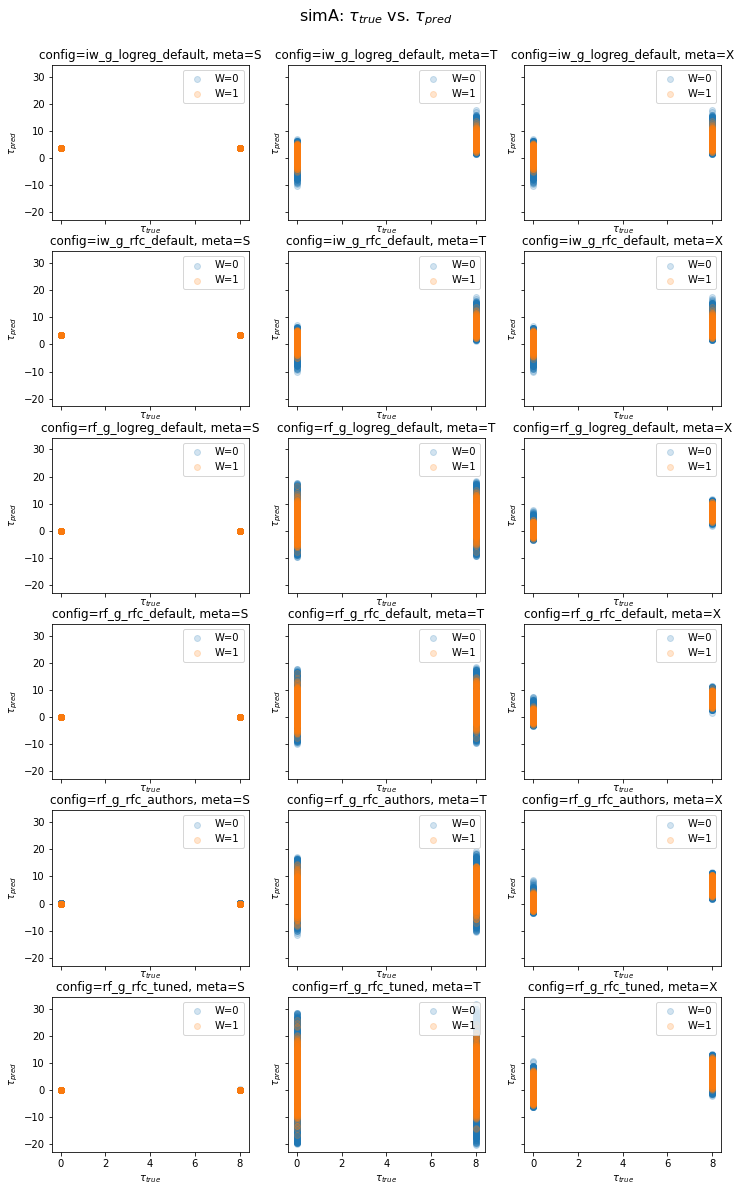

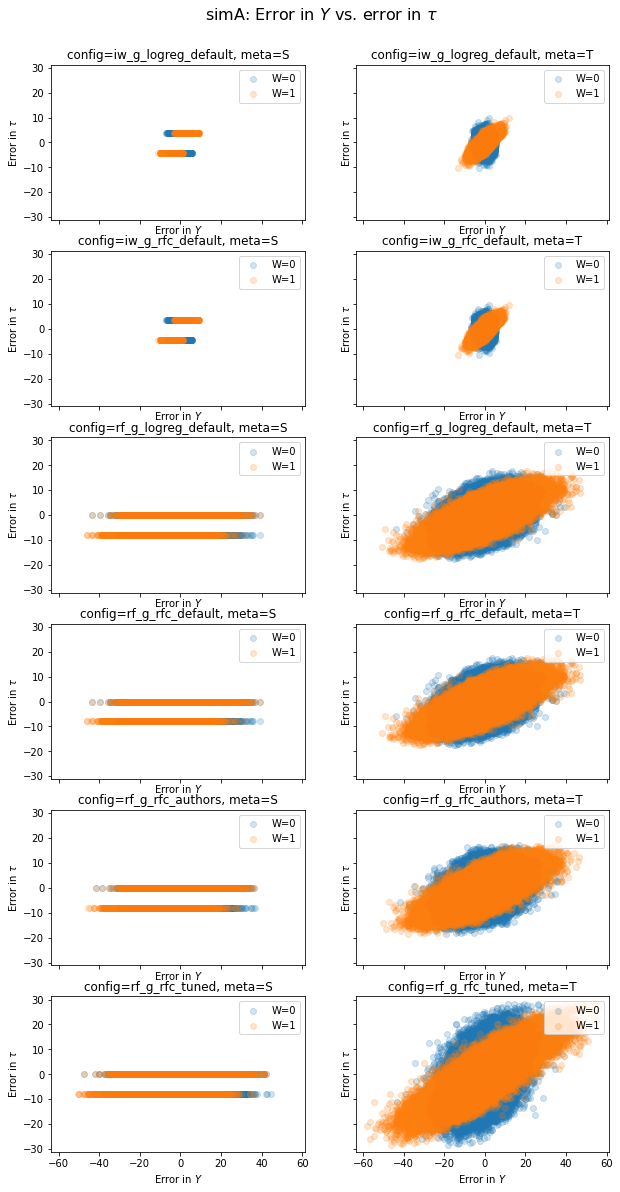

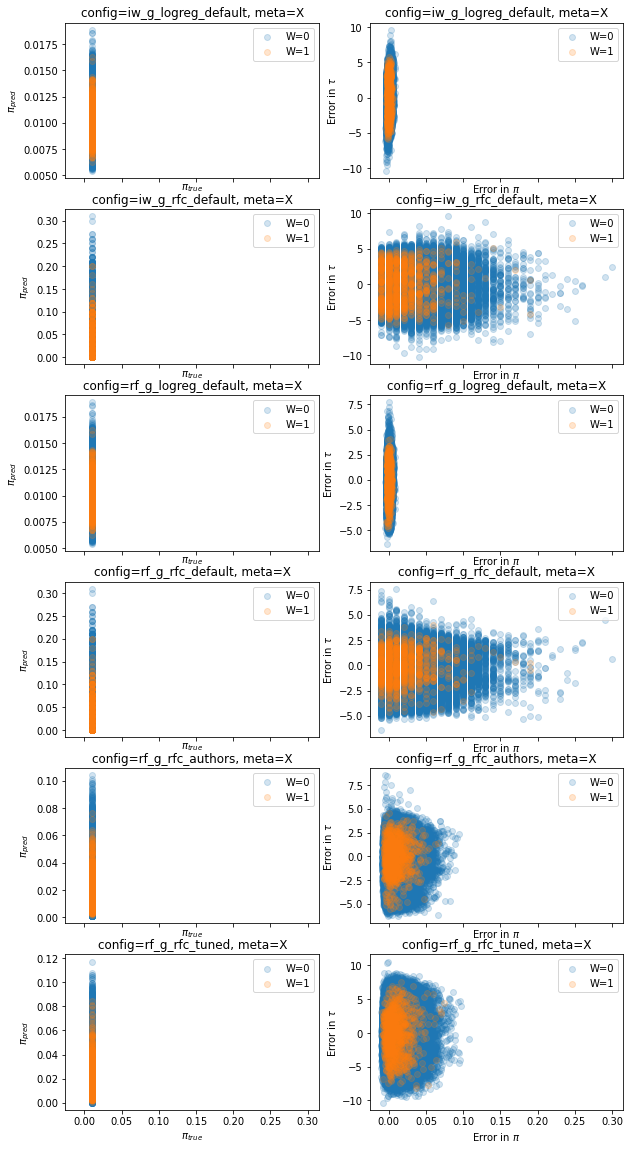

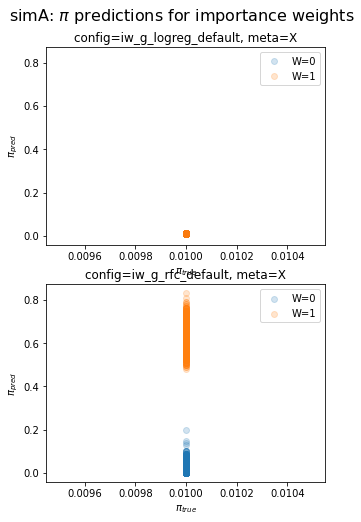

In [4]:
get_plots('A', all_configs)

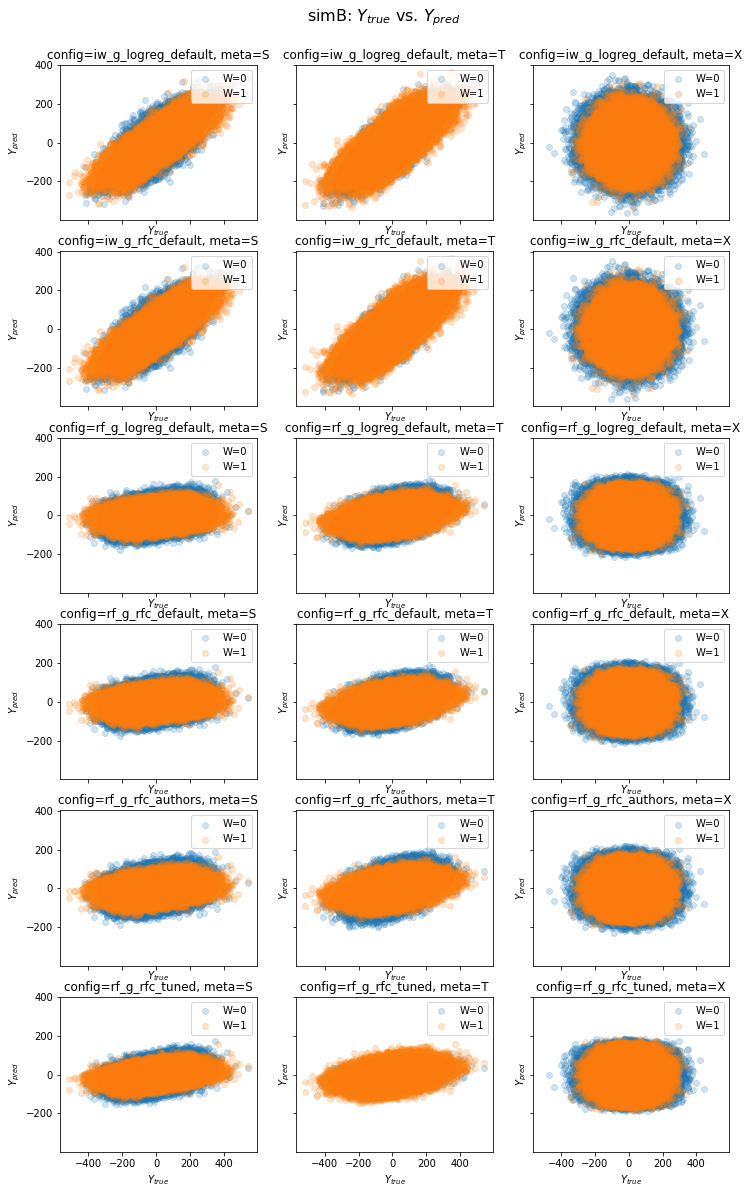

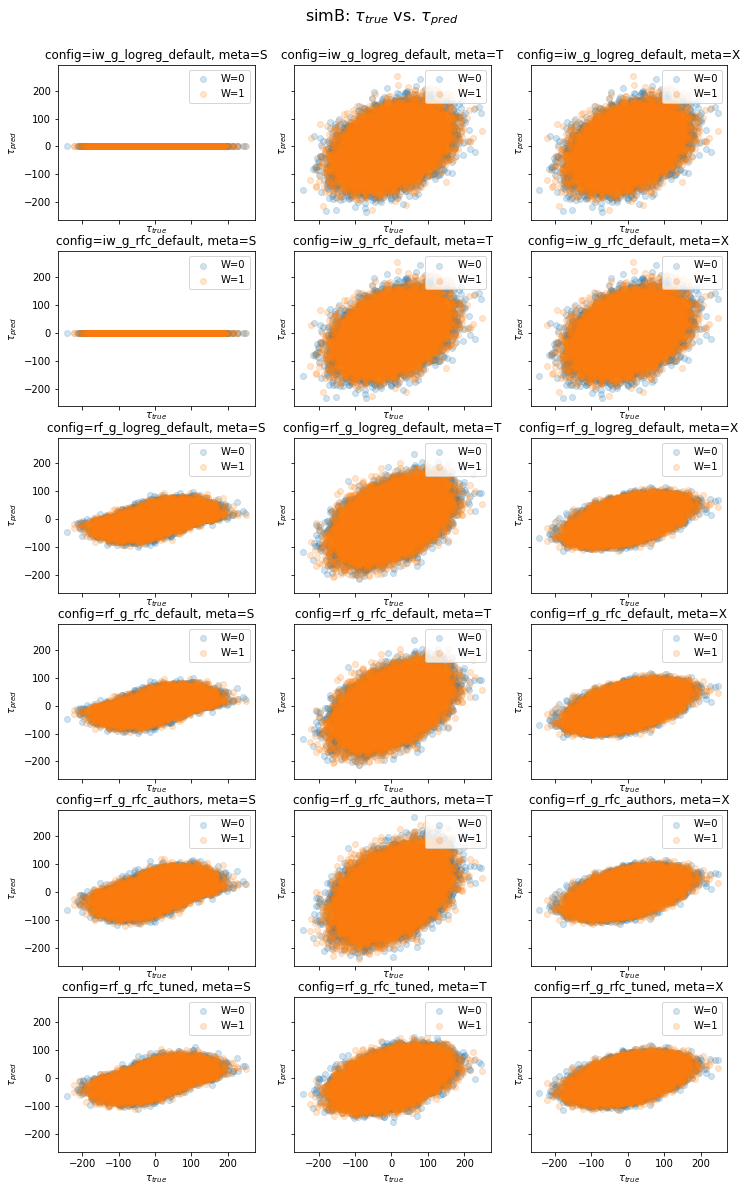

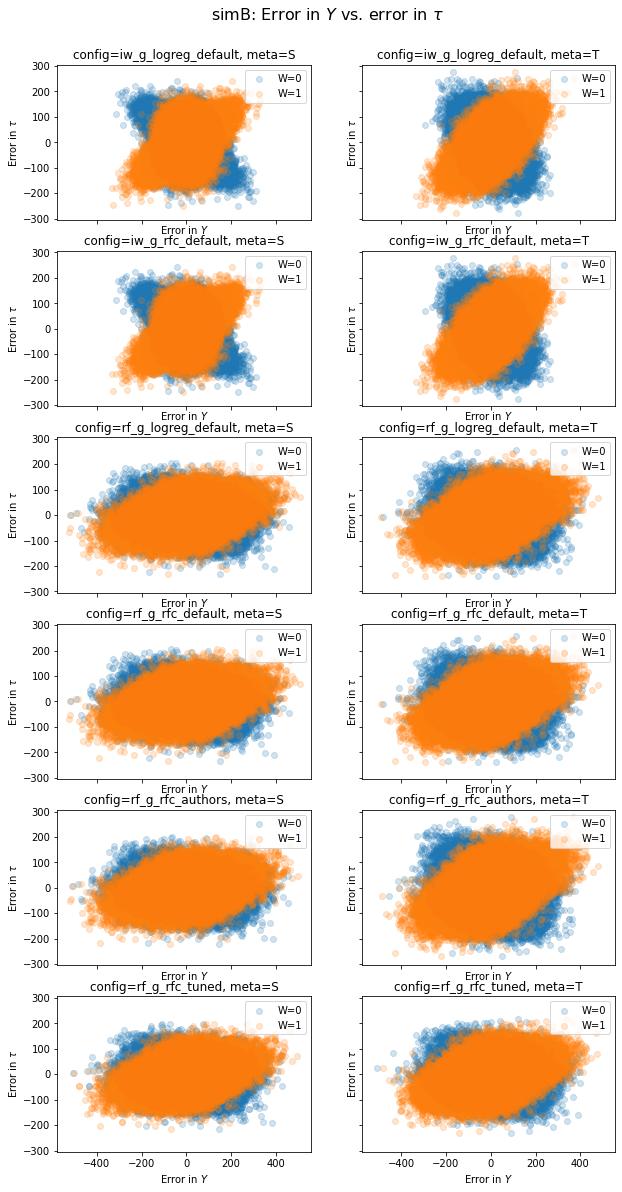

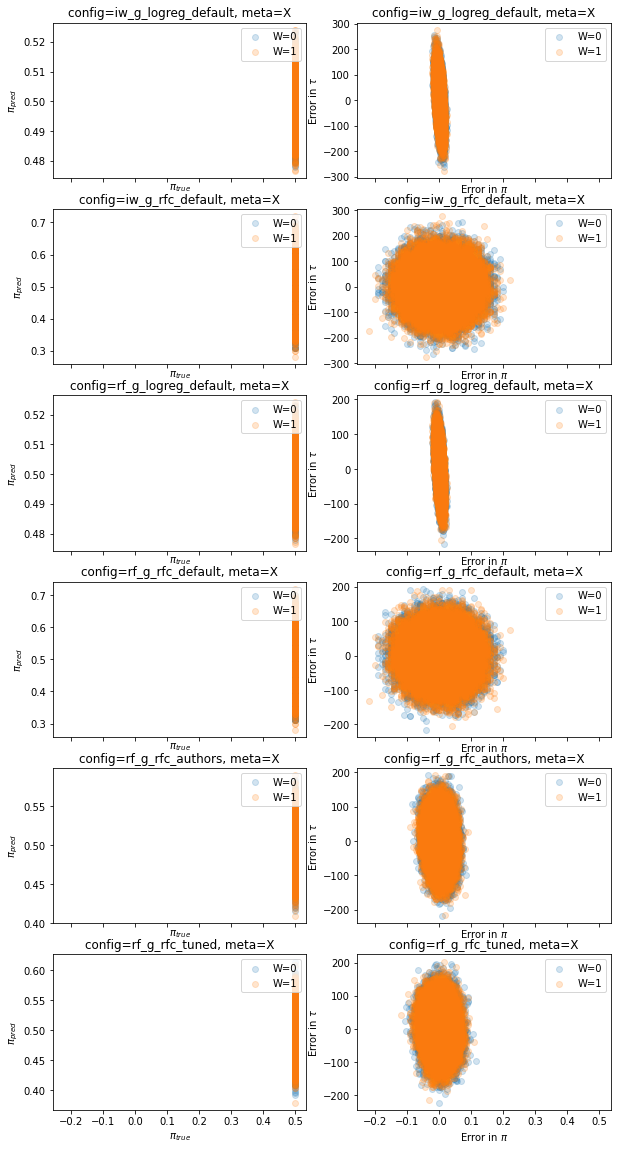

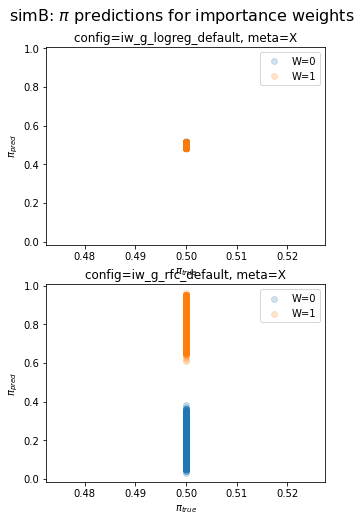

In [5]:
get_plots('B', all_configs)

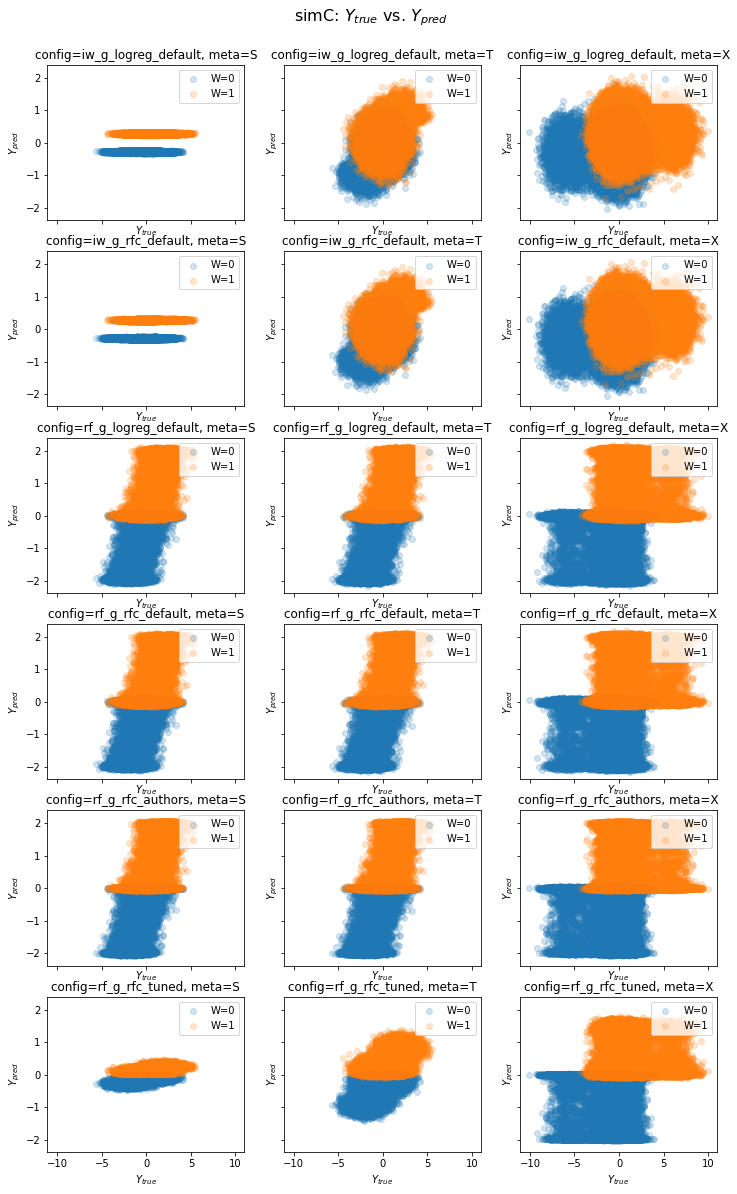

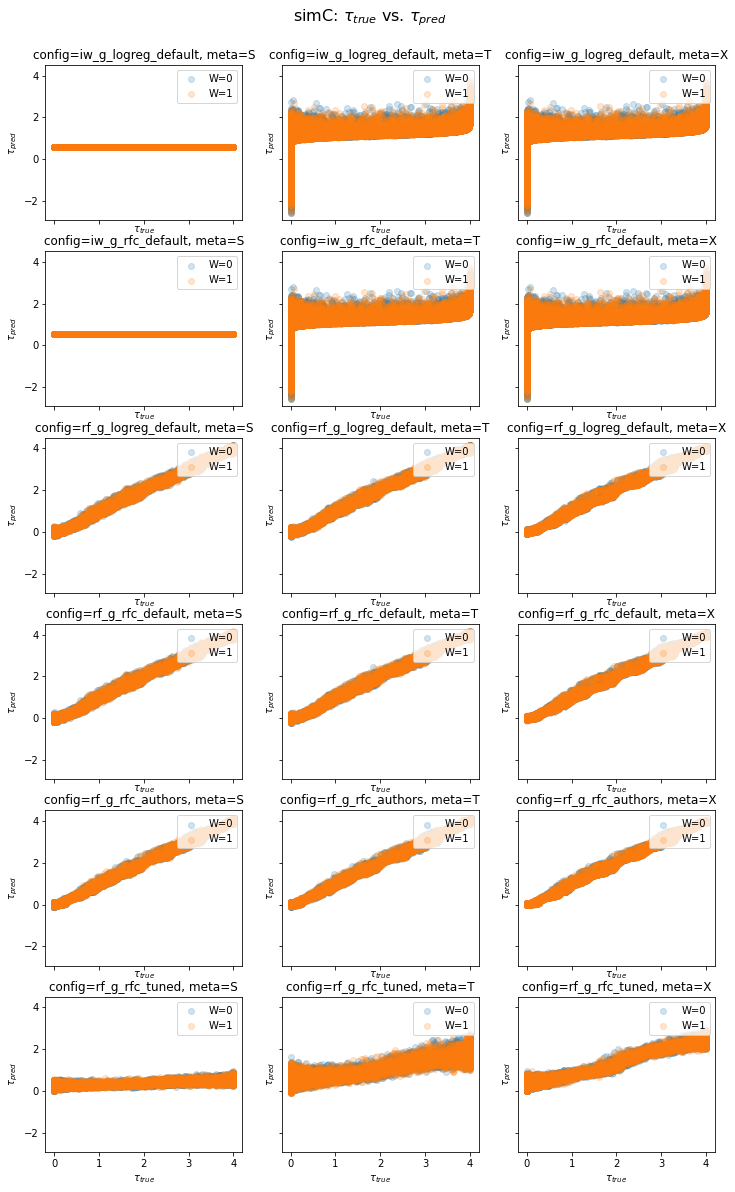

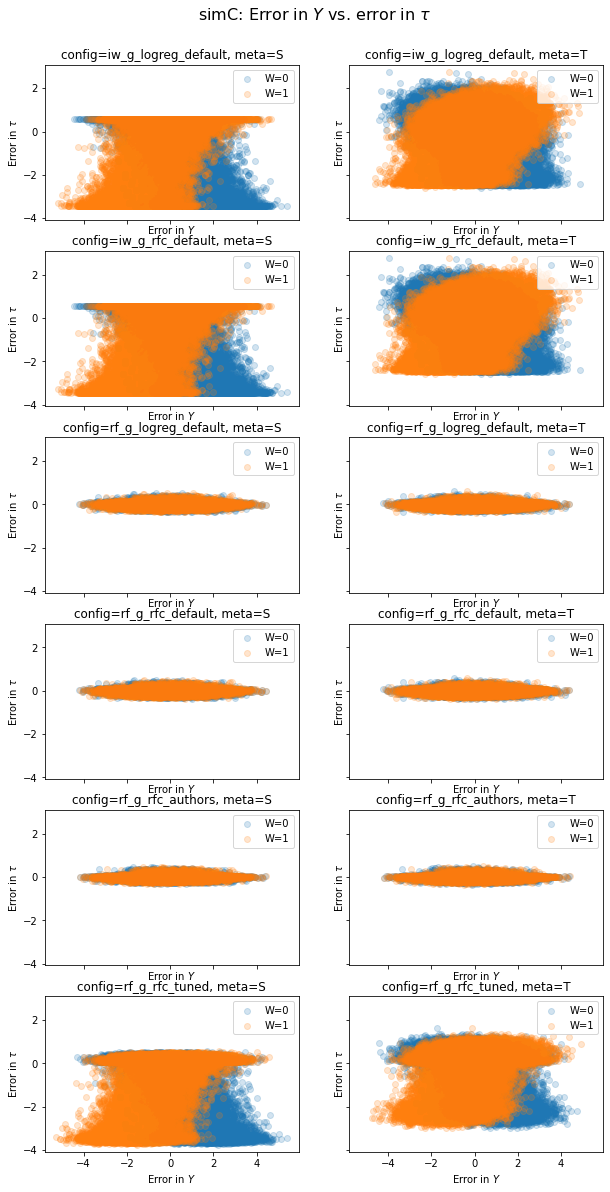

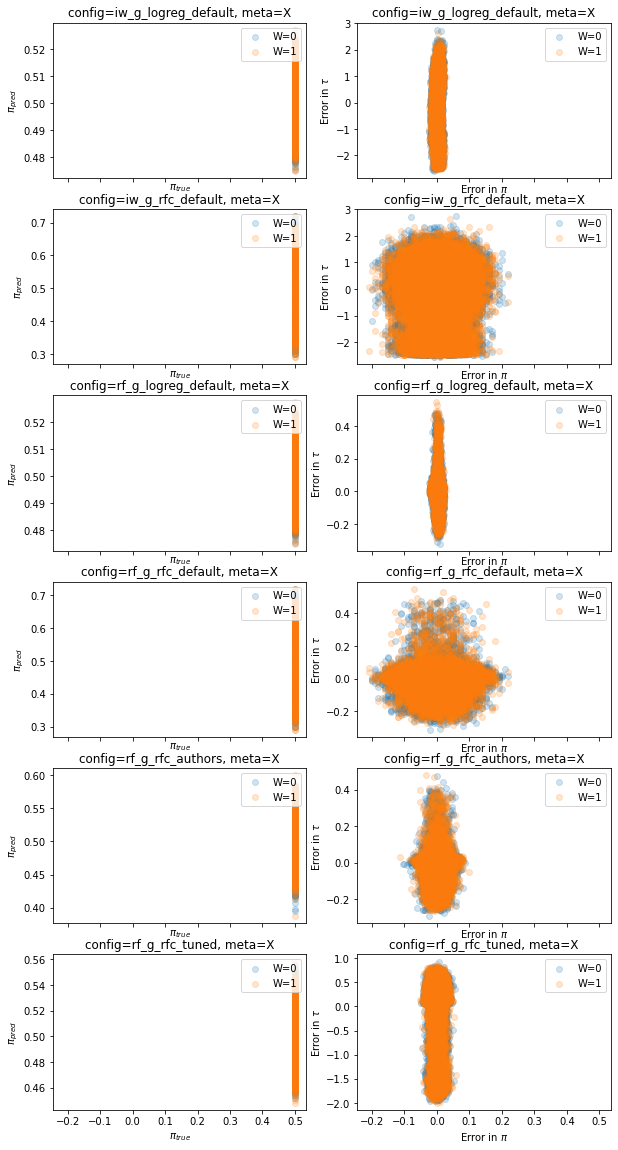

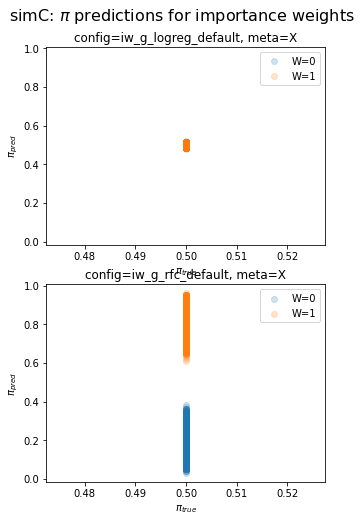

In [6]:
get_plots('C', all_configs)

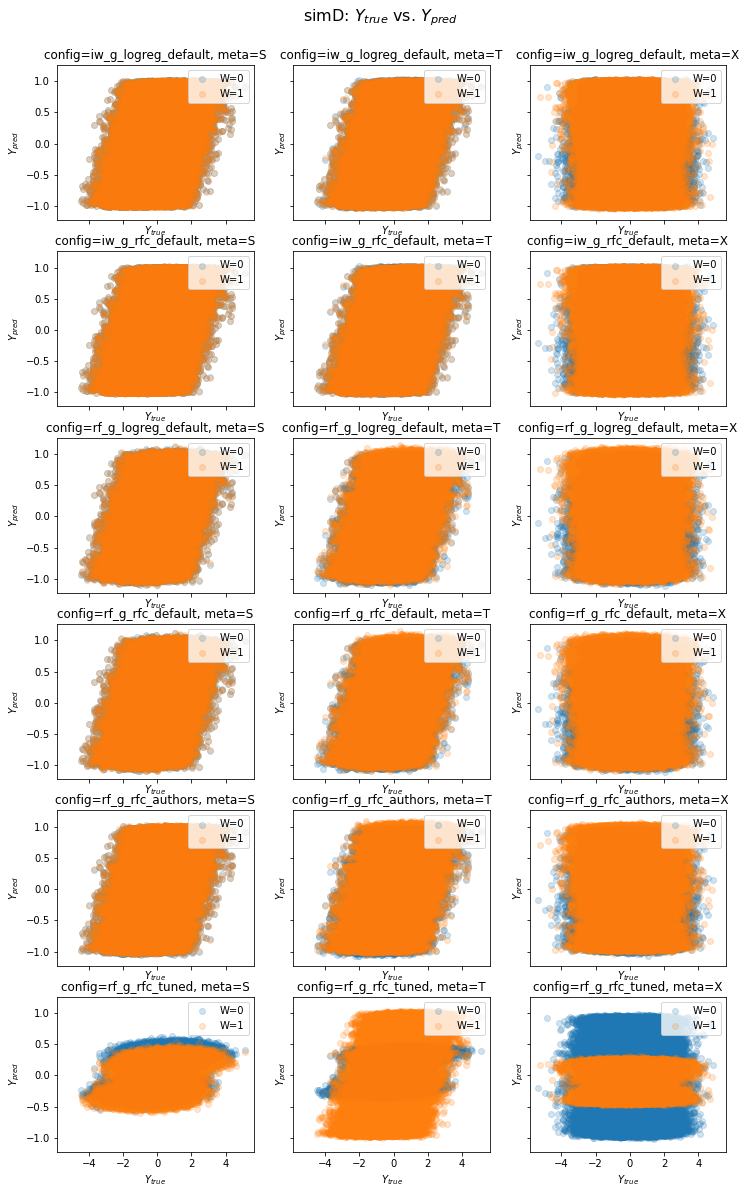

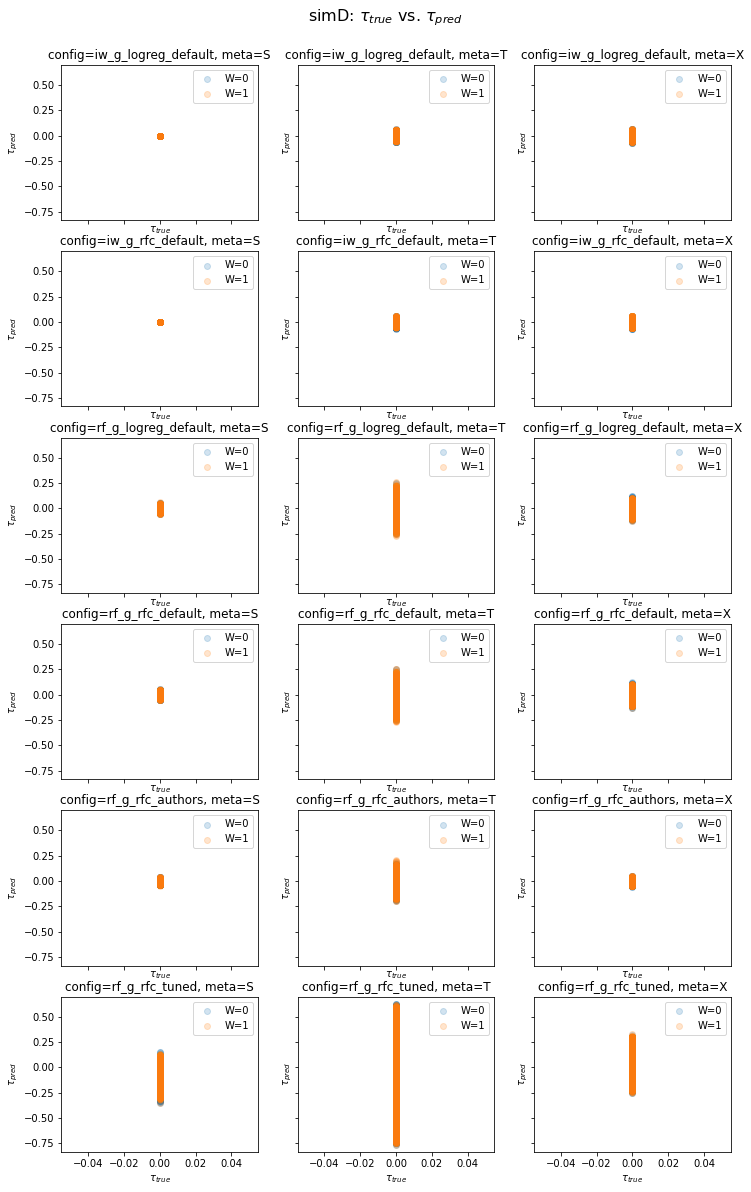

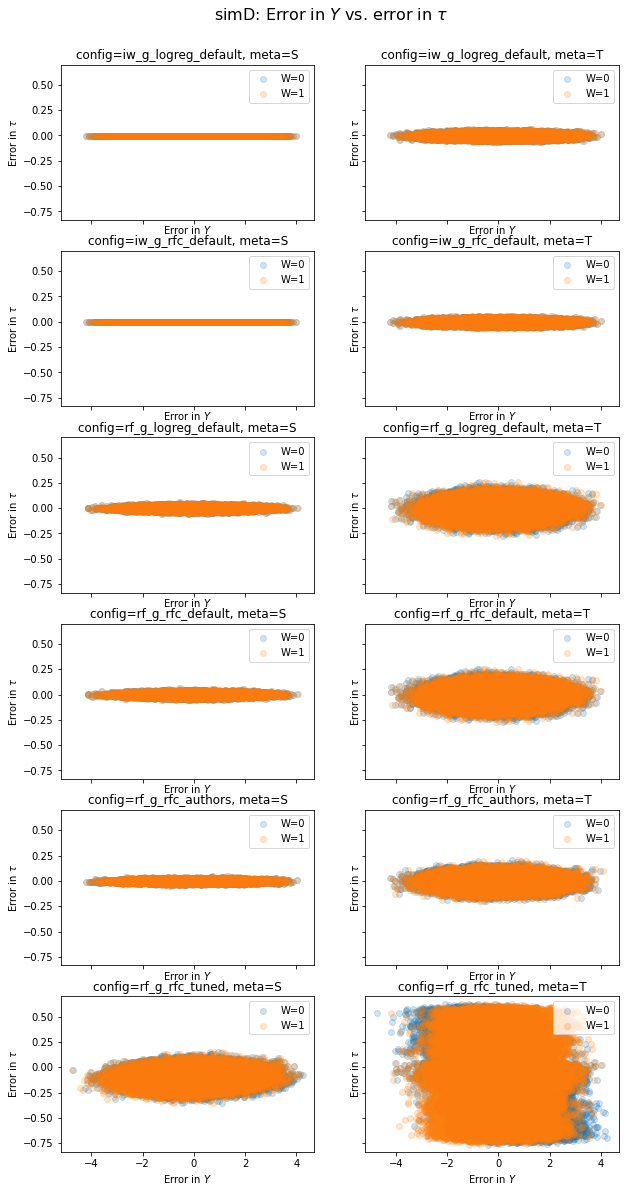

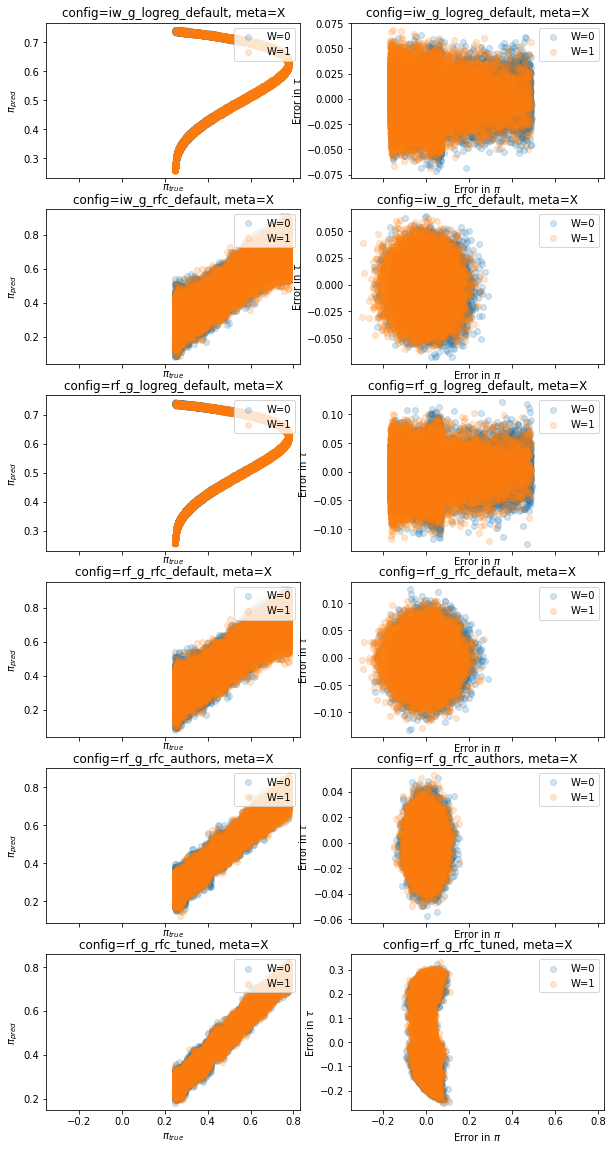

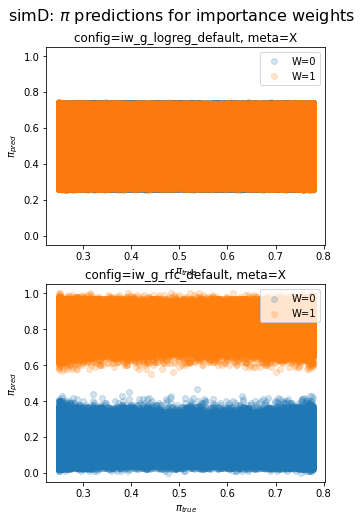

In [7]:
get_plots('D', all_configs)

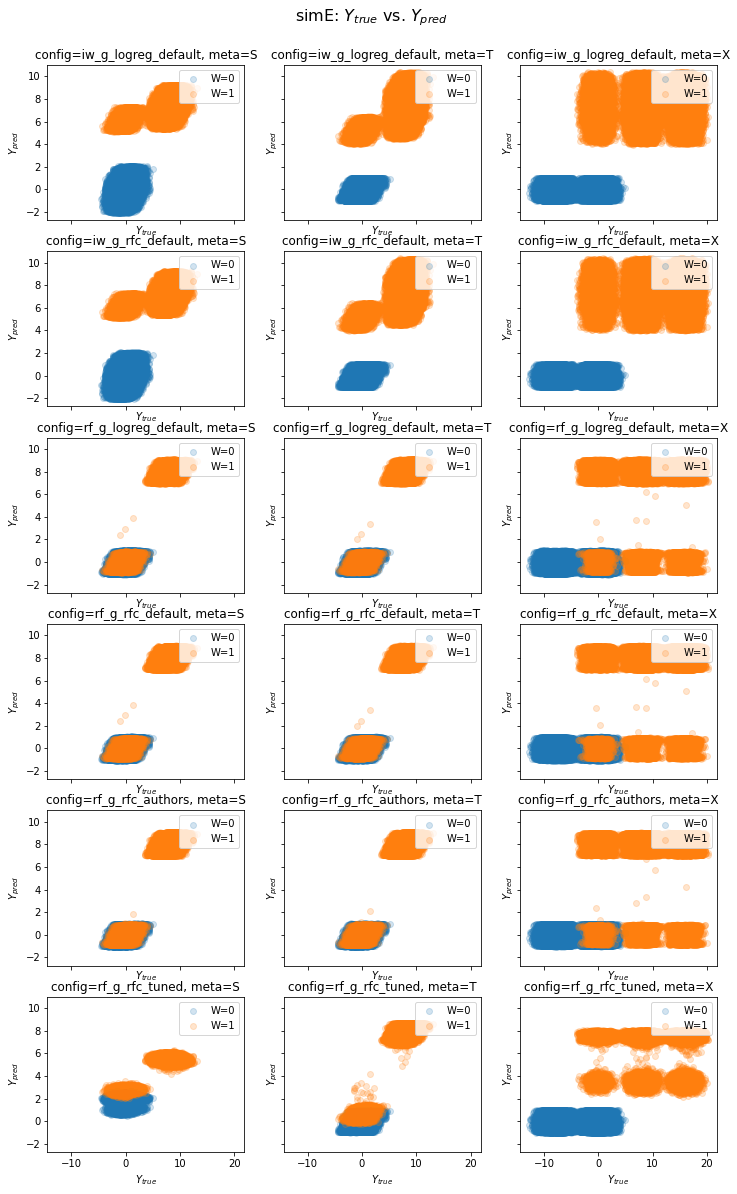

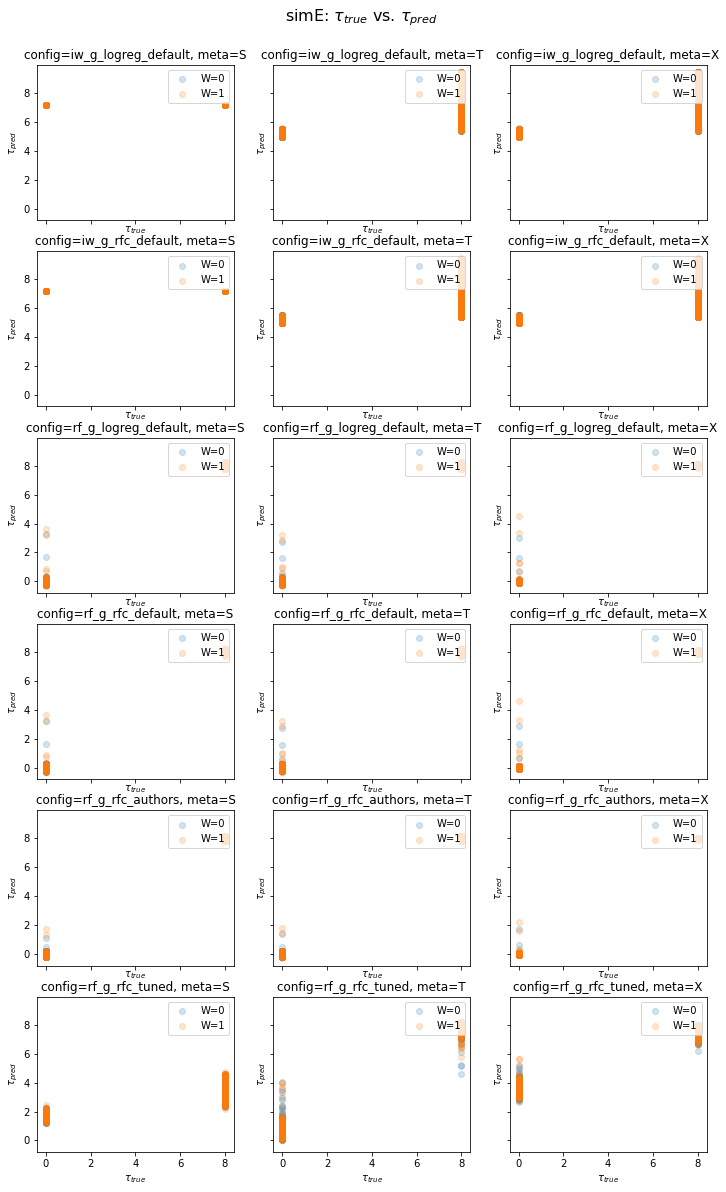

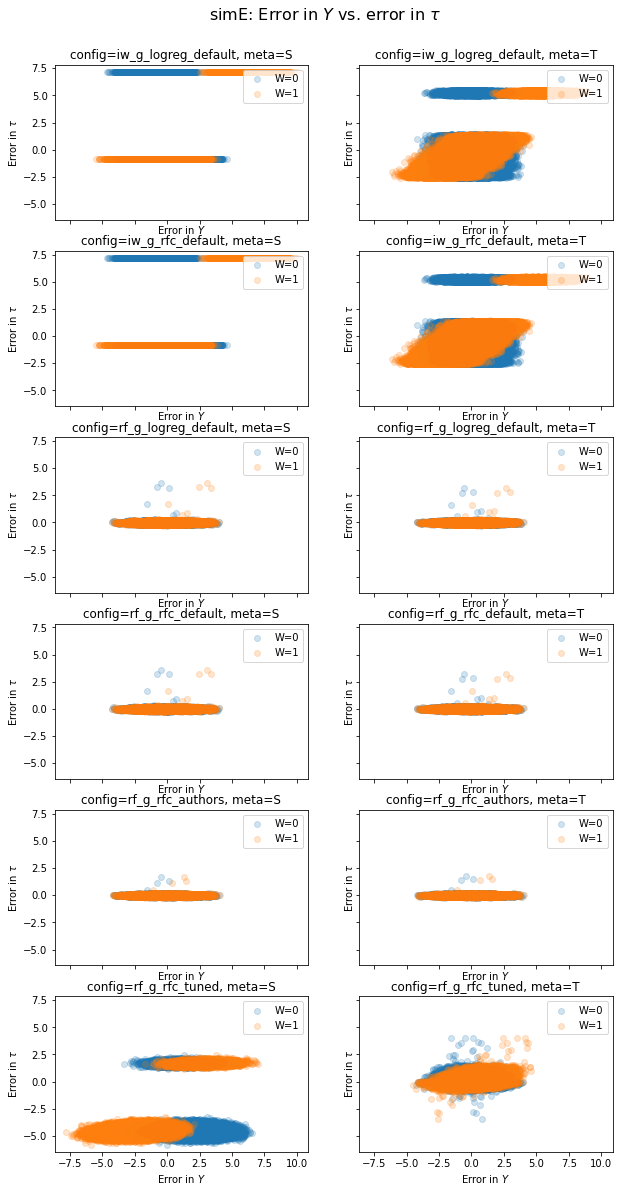

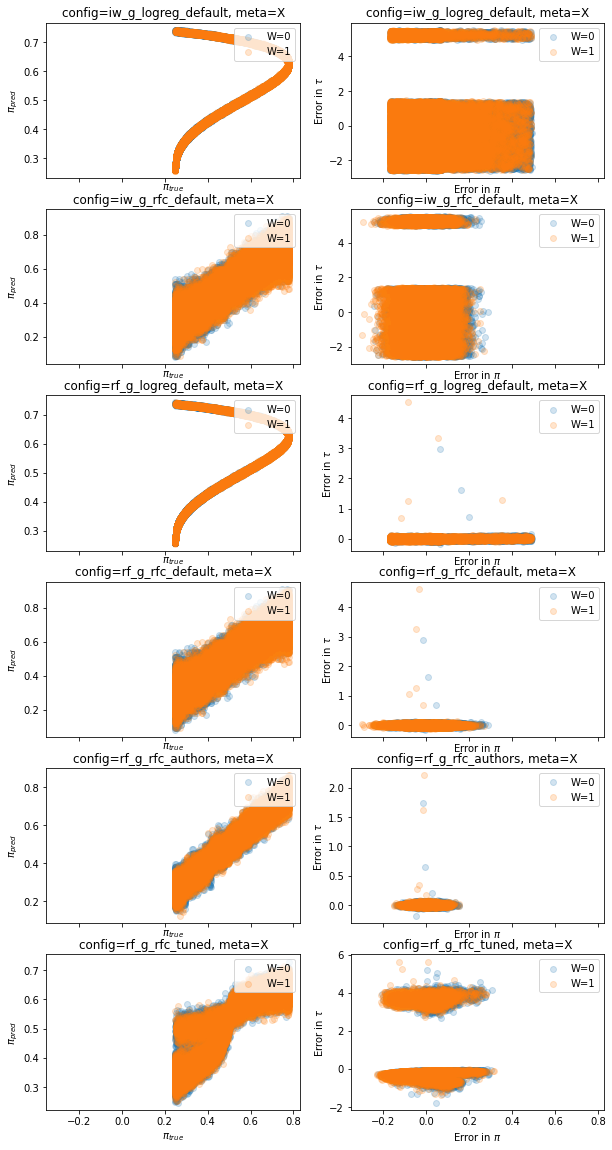

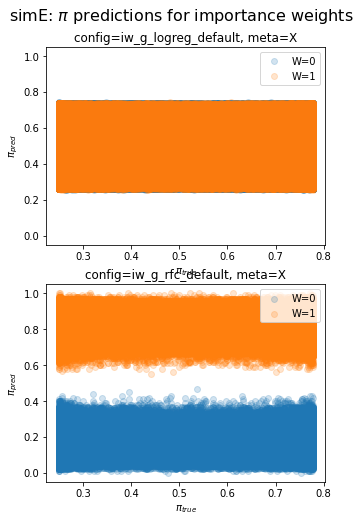

In [8]:
get_plots('E', all_configs)

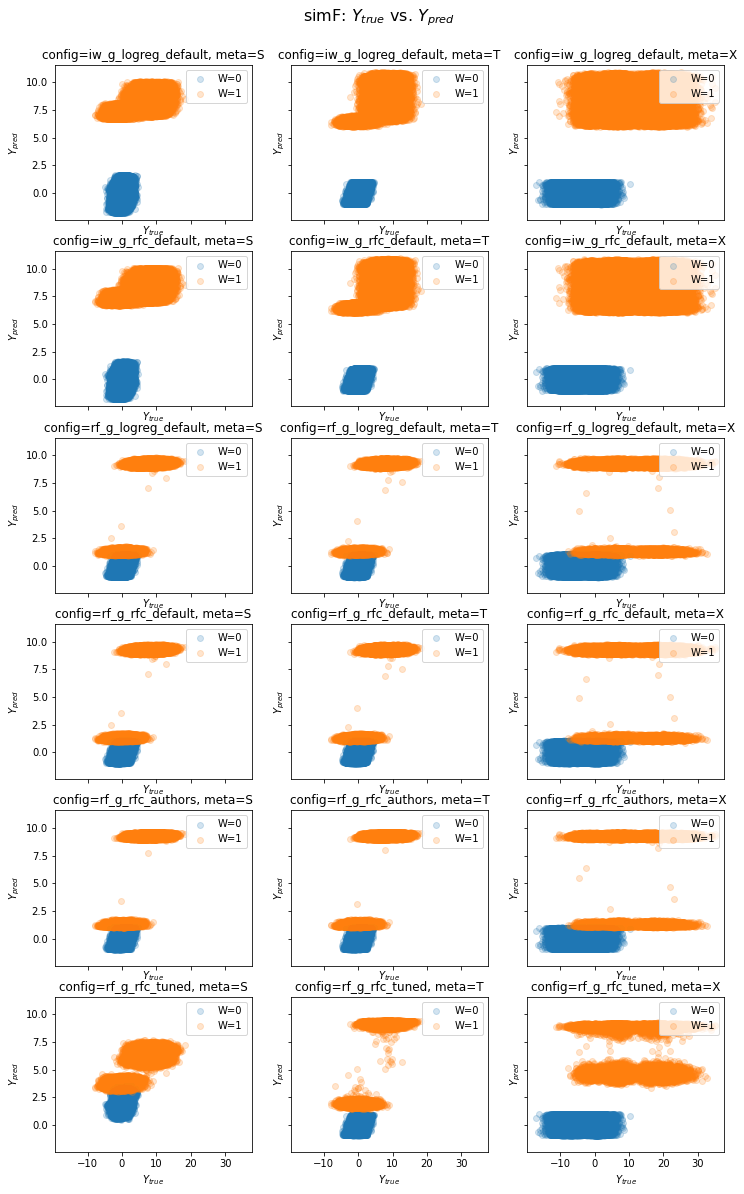

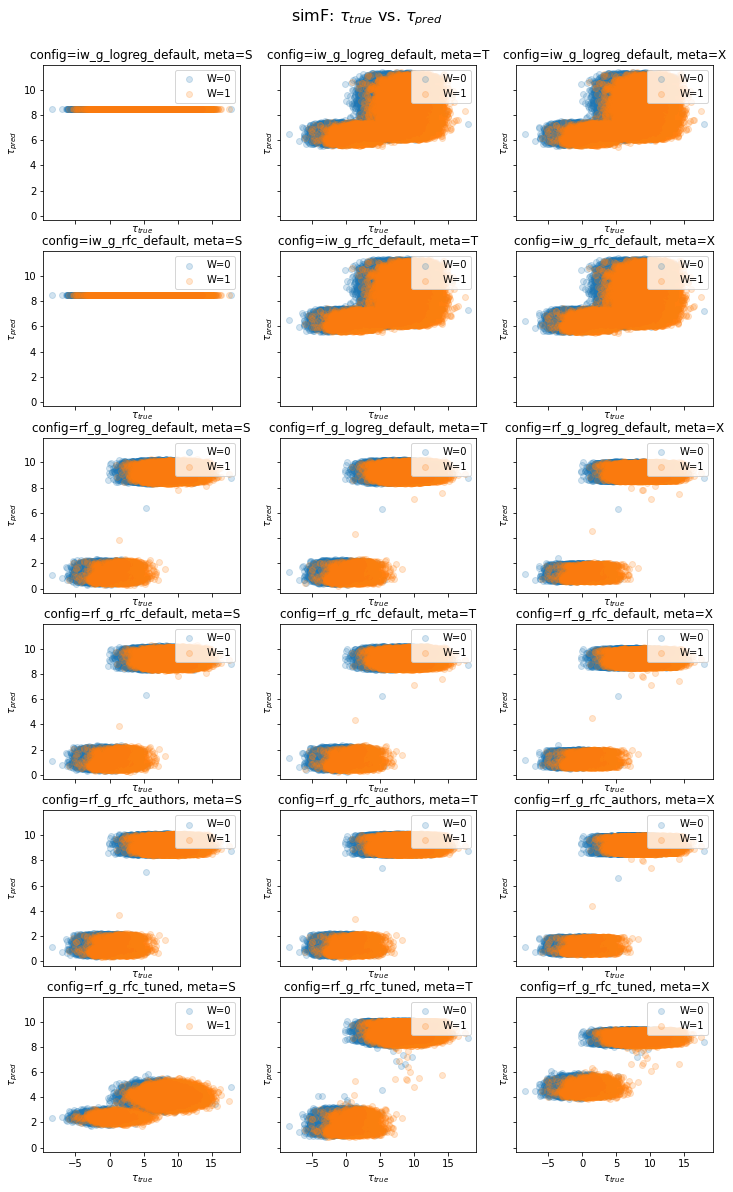

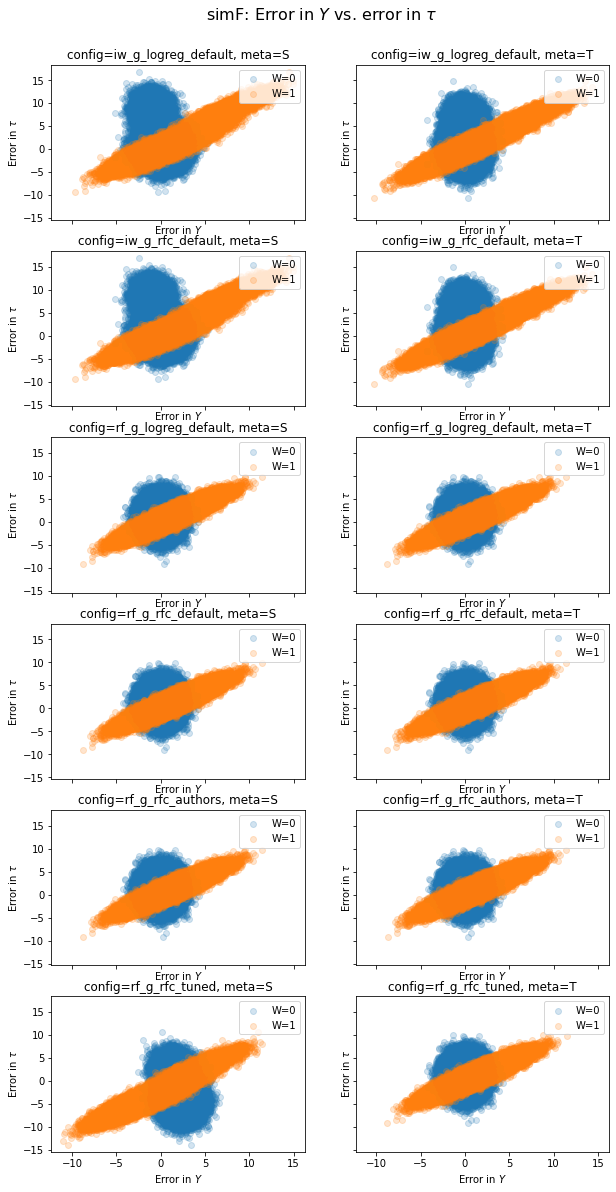

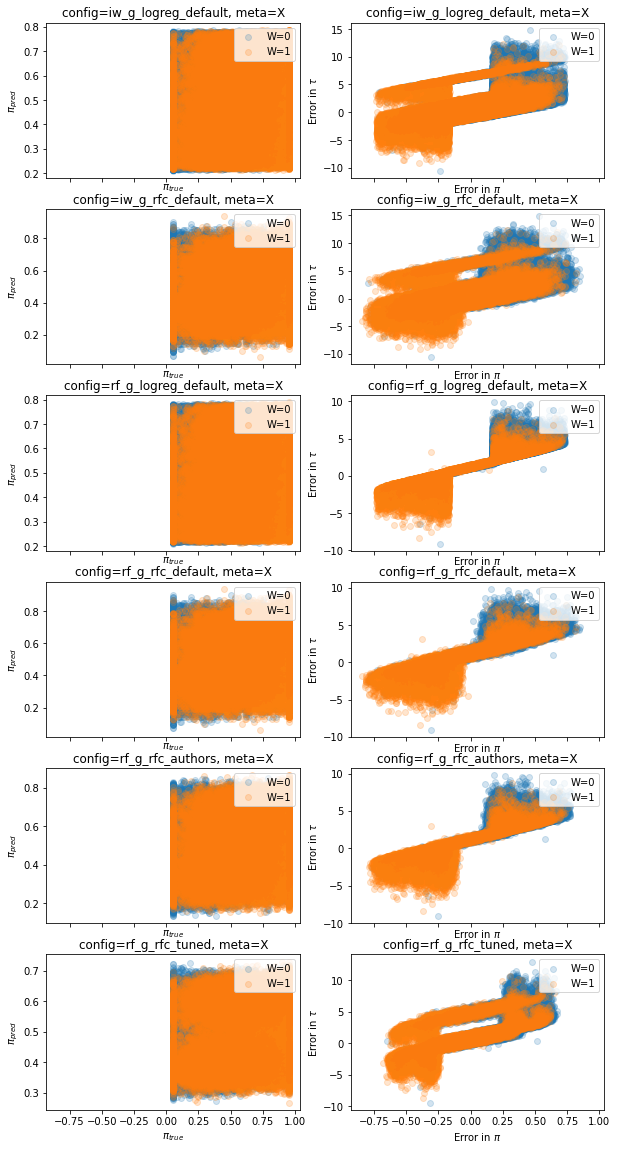

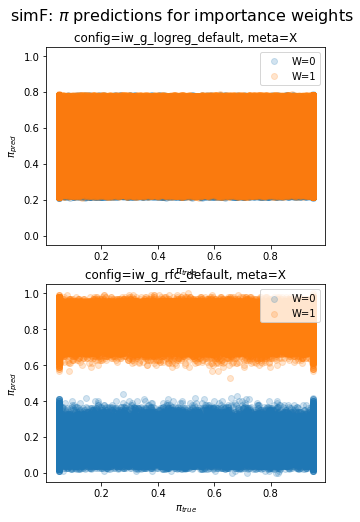

In [9]:
get_plots('F', all_configs)